# Explaining SingleNN and CausalSingleNN 

This script runs an offline diagnostic that "evaluate" and explain the output of the SingleNNs and CausalSingleNN via the DeepExplainer of the SHAP (SHapley Additive exPlanations). DeepExplainer is part of a game theoretic approach that connects optimal credit allocation with local explanations using the classic Shapley values.

"Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT described in the SHAP NIPS paper (https://arxiv.org/abs/1704.02685). The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. Note that some of these enhancements have also been since integrated into DeepLIFT."

See details on the main repository: https://github.com/slundberg/shap


## Packages, Modules & Definitions 

In [1]:
import sys; sys.path.append("..")

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import os, pickle, glob
import numpy    as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# from matplotlib.lines import Line2D
from pathlib import Path

from utils.variable import Variable_Lev_Metadata
from utils.setup import SetupNeuralNetworks
from utils.setup import SetupDiagnostics
from utils.pcmci_aggregation import get_matrix_idx
from utils.plotting import plot_matrix
from neural_networks.cbrain.cam_constants  import *
from neural_networks.models import generate_models
from neural_networks.load_models import load_models, get_var_list
from neural_networks.model_diagnostics import ModelDiagnostics
from neural_networks.load_models import get_save_plot_folder

# plotting
from utils.setup import SetupDiagnostics
from neural_networks.load_models import get_var_list
from utils.variable import Variable_Lev_Metadata


Instructions for updating:
non-resource variables are not supported in the long term


/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages/tigramite-5.0.1.5-py3.8.egg/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages/tigramite-5.0.1.5-py3.8.egg/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages/tigramite-5.0.1.5-py3.8.egg/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))
/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages/tigramite-5.0.1.5-py3.8.egg/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages/tigramite-5.0.1.5-py3.8.egg/tigramite/../versions.py'
  warnings.warn(str(e))
/work/bd1179/b309172/mambaforge/envs/causalnncam/lib/python3.8/site-packages

In [2]:
def get_path(setup, base_path=''):
        """ Generate a path based on this model metadata """
        path = Path(base_path)
        str_hl = str(setup.hidden_layers).replace(", ", "_")
        str_hl = str_hl.replace("[", "").replace("]", "")
        path = path / Path(
            "hl_{hidden_layers}-act_{activation}-e_{epochs}/".format(
                hidden_layers=str_hl,
                activation=setup.activation,
                epochs=setup.epochs,
            )
        )
        return path
    
    
def get_dict(pathnm, outFile):

    if os.path.isfile(str(pathnm)+'/'+outFile):
        print(f'{outFile} exists; loading...')
        infile    = open(str(pathnm)+'/'+outFile,'rb')
        eval_dict = pickle.load(infile)
        infile.close()
    else:
        print(f'{outFile} does not exists; create empty dictionary...')
        eval_dict = {}
    
    return eval_dict


def save_dict(eval_dict, pathnm, outFile, verbose=0):
    if verbose > 0:
        print(f"Save dict: {str(pathnm)}/{outFile}")
    outfile = open(str(pathnm)+'/'+outFile,'wb')
    pickle.dump(eval_dict,outfile)
    outfile.close()

# Options

In [3]:
eval_cases  = ['0k'] # ['0k', 'm4k', 'p4k']
statsnm     = 'shap'
metric      = 'abs_mean' # 'mean', 'abs_mean', 'abs_mean_sign'
nTime       = 1440 # 1440 # ~1-month
nSamples    = 4096 # 1024; 2048; 4096; 8192 # int(setup.batch_size*8) # batch_size (1024) * 8 = SPCAM grid (128*64=8192)

## Reference (Rasp et al. architecture): SingleNN & CausalNN Full profiles

In [4]:
def shap_xai(eval_cases, cfg_str, outPath_dict, outFile_dict_str, nTime, nSamples, metric):
    for i, iCase in enumerate(eval_cases):
    
        print(f'Case: {iCase}')

        # argv    = ["-c", f"./{cfg_str}_{iCase}-test.yml"]
        argv    = ["-c", f"./{cfg_str}_{iCase}.yml"]
        outFile = f'{outFile_dict_str}_nTime-{nTime}_nSamples-{nSamples}_{statsnm}-{metric}.pkl'

        setup  = SetupDiagnostics(argv)
        models = load_models(setup)

        models_type = [[setup.nn_type],["SingleNN","CausalSingleNN"]][setup.nn_type=='all']

        pathnm = get_path(setup, base_path=outPath_dict)
        if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)
        eval_dict = get_dict(pathnm, outFile)
        if iCase not in eval_dict.keys(): eval_dict[iCase] = {}

        input_list  = get_var_list(setup, setup.spcam_inputs)
        setup.inputs = sorted(
            [Variable_Lev_Metadata.parse_var_name(p) for p in input_list],
            key=lambda x: setup.input_order_list.index(x),
        )

        print('')

        for iMod, model_type in enumerate(models_type):
            print(model_type)
            if model_type == 'SingleNN':

                md = ModelDiagnostics(setup = setup, models=models[model_type])

                if 'SingleNN' not in eval_dict[iCase].keys(): eval_dict[iCase][model_type] = {}
                for var in models[model_type].keys():

                    if var.var.value not in eval_dict[iCase][model_type].keys(): 
                        eval_dict[iCase][model_type][var.var.value] = {}
                        shape = ma.masked_equal(ma.zeros([30,len(setup.inputs)]),0.)
                        eval_dict[iCase][model_type][var.var.value] = {
                            statsnm:(statsnm,shape),
                            'lab':model_type,
                        }
                        # save_dict(eval_dict, pathnm, outFile, verbose=1)

                    i_level = var.level_idx if var.level_idx != None else 29
                    if ma.is_masked(ma.mean(eval_dict[iCase][model_type][var.var.value][statsnm][1][i_level])):
                        print(f'evaluate: {var}')

                        # model, X_train, X_test, input_vars_dict = md.get_shapley_values('range', var, nTime=nTime)
                        shap_values_mean, inputs, input_vars_dict = md.get_shapley_values('range', var, nTime=nTime, nSamples=nSamples, metric=metric)
                        eval_dict[iCase][model_type][var.var.value][statsnm][1][i_level] = shap_values_mean

                        # Save to pickle object
                        save_dict(eval_dict, pathnm, outFile)

                        print()

                print('\n \n')


            elif model_type == 'CausalSingleNN':
                for pc_alpha in models[model_type].keys():
                    for threshold in models[model_type][pc_alpha].keys():
                        print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                        md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                        c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                        print(f'c_model_type: {c_model_type}')
                        print('here')
                        if c_model_type not in eval_dict[iCase].keys(): eval_dict[iCase][c_model_type] = {}
                        for var in models[model_type][pc_alpha][threshold].keys():

                            if var.var.value not in eval_dict[iCase][c_model_type].keys(): 
                                eval_dict[iCase][c_model_type][var.var.value] = {}
                                shape = ma.masked_equal(ma.zeros([30,len(setup.inputs)]),0.)
                                eval_dict[iCase][c_model_type][var.var.value] = {
                                    statsnm:(statsnm,shape),
                                    'lab':model_type,
                                }

                            i_level = var.level_idx if var.level_idx != None else 29
                            if ma.is_masked(ma.mean(eval_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level])):
                                print(f'evaluate: {var}')

                                shap_values_mean, inputs, input_vars_dict = md.get_shapley_values('range', var, nTime=nTime, nSamples=nSamples, metric=metric)
                                eval_dict[iCase][c_model_type][var.var.value][statsnm][1][i_level][inputs] = shap_values_mean

                                # Save to pickle object
                                save_dict(eval_dict, pathnm, outFile)

                                print()

                        print('\n \n')

        print('\n \n \n')
    
    return eval_dict

In [5]:
# SingleNN (Rasp; act-LeakyReLU)
singlenn_arch_rasp_dict = shap_xai(
    eval_cases, 
    'nn_config/220804_xai/cfg_singlenn_rasp_full-profiles', 
    'shap_dicts_singlenn', 
    'offline_shap_full-profiles', 
    nTime, 
    nSamples,
    metric
)

Case: 0k
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_0_model.h5


2022-12-17 21:09:57.631742: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 21:09:57.632463: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 21:09:57.632770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l30200.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2022-12-17 21:09:57.680336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_1_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_6_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_7_model.h5
Load model: models_causal_links-tb_train-tb/SingleNN/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_8_model.h5
Load mod

In [6]:
# CausalNN (Rasp; act-LeakyReLU; thr-0.59)
causalnn_arch_rasp_thr59_dict = shap_xai(
    eval_cases, 
    'nn_config/220804_xai/cfg_causalnn_rasp_full-profiles', 
    'shap_dicts_causalnn', 
    'offline_shap_full-profiles', 
    nTime, 
    nSamples,
    metric
)


Case: 0k
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_0_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_1_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_2_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_3_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_4_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_5_model.h5
Load model: models_causal_links-tb_train-tb/CausalSingleNN/a0.01-t0.59-latwts/hl_256_256_256_256_

## Optimized cases

In [6]:
def shap_xai_optimized(eval_cases, cfg_path, SHE_path, model_types, base_path, nTime, nSamples, cfg_path_model_type=False):

    SHE_dict = {}
    for i, iCase in enumerate(eval_cases):

        print(f'Case: {iCase} \n')
        SHE_dict[iCase] = {}

        # outFile = f'offline_SHERPA_full-profiles_nTime-{str(nTime)}.pkl'
        outFile = f'offline_SHERPA_full-profiles_nTime-{str(nTime)}_nSamples-{nSamples}_{statsnm}-{metric}.pkl'

        for i, model_type in enumerate(model_types):

            print(f"Process model_type: {model_type}")

            # config files
            if not cfg_path_model_type:
                cfg_type = 'single' if model_type == 'SingleNN' else 'pdf'
                cfg_path_model_type = cfg_path+cfg_type
            cfg_files = glob.glob(cfg_path_model_type+'/*.yml')

            for j, cfg_file in enumerate(cfg_files):
                print(cfg_file)
                argv  = ["-c", cfg_file]
                setup = SetupDiagnostics(argv)
                if iCase == '0k':
                    setup.test_data_folder = './SPCAM_tb_preproc'
                    setup.test_data_fn     = '2021_09_02_TEST_For_Nando.nc'
                else:
                    setup.test_data_folder = './Aqua_Generalization_Test_Sets'
                    if iCase == 'm4k':
                        setup.test_data_fn = '2022_02_07_TEST_For_Nando_m4K.nc'
                    else: 
                        setup.test_data_fn = '2022_02_07_TEST_For_Nando_p4K.nc'
                models = load_models(setup)
                
                input_list  = get_var_list(setup, setup.spcam_inputs)
                setup.inputs = sorted(
                    [Variable_Lev_Metadata.parse_var_name(p) for p in input_list],
                    key=lambda x: setup.input_order_list.index(x),
                )

                pathnm = get_path(setup, base_path=base_path)
                if not os.path.exists(pathnm): Path(pathnm).mkdir(parents=True, exist_ok=True)

                # outFile = f'offline_eval-{statsnm}_nTime-{str(nTime)}.pkl'

                sens_dict = get_dict(pathnm, outFile)
                if iCase not in sens_dict.keys(): sens_dict[iCase] = {}

                if model_type not in SHE_dict[iCase].keys(): SHE_dict[iCase][model_type] = {}
                if model_type not in sens_dict[iCase].keys(): sens_dict[iCase][model_type] = {}

                if model_type == 'SingleNN':

                    md = ModelDiagnostics(setup = setup, models=models[model_type])

                    for var in models[model_type].keys():

                        shape = ma.masked_equal(ma.zeros([30,len(setup.inputs)]),0.)
                        
                        if var.var.value not in sens_dict[iCase][model_type].keys(): 
                            sens_dict[iCase][model_type][var.var.value] = {}
                            sens_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,shape),
                                'lab':model_type,
                            }
                        
                        if var.var.value not in SHE_dict[iCase][model_type].keys(): 
                            SHE_dict[iCase][model_type][var.var.value] = {}
                            SHE_dict[iCase][model_type][var.var.value] = {
                                statsnm:(statsnm,shape),
                                'lab':model_type,
                            }

                        lev    = var.level_idx if var.level_idx != None else 29; levKey = str(lev)
                        if ma.is_masked(ma.mean(sens_dict[iCase][model_type][var.var.value][statsnm][1][lev])):
                            print(f'evaluate: {var}')

                            shap_values_mean, inputs, input_vars_dict = md.get_shapley_values('range', var, nTime=nTime, nSamples=nSamples, metric=metric)
                            sens_dict[iCase][model_type][var.var.value][statsnm][1][lev] = shap_values_mean

                            # Save to pickle object
                            save_dict(sens_dict, pathnm, outFile)
                        if ma.is_masked(ma.mean(SHE_dict[iCase][model_type][var.var.value][statsnm][1][lev])):
                            SHE_dict[iCase][model_type][var.var.value][statsnm][1][lev] = \
                            sens_dict[iCase][model_type][var.var.value][statsnm][1][lev]


                else:
                    for pc_alpha in models[model_type].keys():
                        for threshold in models[model_type][pc_alpha].keys():
                            print(f"pc_alpha-threshold: {pc_alpha}-{threshold}")

                            md = ModelDiagnostics(setup = setup, models=models[model_type][pc_alpha][threshold])

                            c_model_type = f'{model_type}_{pc_alpha}_{threshold}'
                            if c_model_type not in SHE_dict[iCase][model_type].keys(): 
                                SHE_dict[iCase][model_type][c_model_type] = {}
                            if c_model_type not in sens_dict[iCase][model_type].keys(): 
                                sens_dict[iCase][model_type][c_model_type] = {}

                            for var in models[model_type][pc_alpha][threshold].keys():

                                shape = ma.masked_equal(ma.zeros([30,len(setup.inputs)]),0.)
                                
                                if var.var.value not in sens_dict[iCase][model_type][c_model_type].keys(): 
                                    sens_dict[iCase][model_type][c_model_type][var.var.value] = {}
                                    sens_dict[iCase][model_type][c_model_type][var.var.value] = {
                                        statsnm:(statsnm,shape),
                                        'lab':model_type,
                                    }

                                if var.var.value not in SHE_dict[iCase][model_type][c_model_type].keys(): 
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value] = {}
                                    stats = ma.masked_equal(ma.array([0.]*len(setup.levels)),0.)
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value] = {
                                        statsnm:(statsnm,shape),
                                        'lab':model_type,
                                    }

                                lev    = var.level_idx if var.level_idx != None else 29; levKey = str(lev)
                                # print(var, lev, sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev])
                                # if 'tphystnd' in var.var.value and lev == 12:
                                if ma.is_masked(ma.mean(sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev])):
                                    print(f'evaluate: {var}')

                                    shap_values_mean, inputs, input_vars_dict = md.get_shapley_values('range', var, nTime=nTime, nSamples=nSamples, metric=metric)
                                    sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev][inputs] = shap_values_mean
                                    
                                    # Save to pickle object
                                    save_dict(sens_dict, pathnm, outFile)

                                if ma.is_masked(ma.mean(SHE_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev])):
                                    SHE_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev] = \
                                    sens_dict[iCase][model_type][c_model_type][var.var.value][statsnm][1][lev]

                print()

            print('\n')

        print('\n')
    
    return SHE_dict

In [7]:
# 220628_rasp_etal_2018_thrs-opt-dict/mse6
cfg_path    = './nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/'
SHE_path    = f'./models_arch-rasp_thrs-opt-mse6/'
model_types = ['CausalSingleNN']
base_path   = 'shap_dicts_causalnn_arch-rasp_thrs-opt-mse6' # shap_dicts_causalnn
cfg_path_model_type = cfg_path

causalnn_arch_rasp_thrs_opt_mse6_dict = shap_xai_optimized(eval_cases, cfg_path, SHE_path, model_types, base_path, nTime, nSamples, cfg_path_model_type=cfg_path_model_type)

for i, iK in enumerate(eval_cases):
    causalnn_arch_rasp_thrs_opt_mse6_dict[iK]['CausalSingleNN_arch-rasp-topt-mse6'] = \
    causalnn_arch_rasp_thrs_opt_mse6_dict[iK]['CausalSingleNN']['CausalSingleNN_0.01_optimized']
    causalnn_arch_rasp_thrs_opt_mse6_dict[iK].pop('CausalSingleNN')

Case: 0k 

Process model_type: CausalSingleNN
./nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/cfg_NN_Creation_rasp_parcorr_thrs-opt-dict_phq-tphystnd_19.yml
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/1_19_model.h5
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/0_19_model.h5
offline_SHERPA_full-profiles_nTime-1440_nSamples-4096_shap-abs_mean.pkl exists; loading...
pc_alpha-threshold: 0.01-optimized

./nn_config/220628_rasp_etal_2018_thrs-opt-dict/mse6/cfg_NN_Creation_rasp_parcorr_thrs-opt-dict_2Ds.yml
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/2_0_model.h5
Load model: models_arch-rasp_thrs-opt-mse6/CausalSingleNN/a0.01-toptimized-latwts/hl_256_256_256_256_256_256_256_256_256-act_LeakyReLU-e_18/3_0_mo

## SHAP matrix

In [8]:
def calc_matrix_shap(
    clima_case,
    nn_case,
    shap_dict,
):

    argv   = ["-c", f"./cfg_shap_matrix.yml"]
    setup  = SetupDiagnostics(argv)
    
    input_list  = get_var_list(setup, setup.spcam_inputs)
    setup.inputs = sorted(
        [Variable_Lev_Metadata.parse_var_name(p) for p in input_list],
        key=lambda x: setup.input_order_list.index(x),
    )

    # inputs sorted as in NN's predictions
    dict_inputs_idx_var = {i:setup.inputs[i] for i in range(len(setup.inputs))}
    dict_inputs_var_idx = dict([(str(value), key) for key, value in dict_inputs_idx_var.items()])

    # Remapping the inputs (idxs) as in causal matrices
    input_list_inv_remap_idx = [dict_inputs_var_idx[i] for i in input_list][::-1]
    input_list_inv_remap_var = [dict_inputs_idx_var[i] for i in input_list_inv_remap_idx]
    input_dict_inv_remap_var = {i:input_list_inv_remap_var[i] for i in range(len(input_list_inv_remap_var))}

    # outputs
    dict_outputs_idxs = {}
    idx = 0
    for child in setup.spcam_outputs:
        if child.dimensions == 2:
            child_levels = [[setup.levels[-1], 0]]
            child_var = Variable_Lev_Metadata(child, None, None)
            dict_outputs_idxs[idx] = child_var
            idx += 1
        elif child.dimensions == 3:
            child_levels = setup.children_idx_levs
        for level in child_levels:
            if child.dimensions == 3:
                child_var = Variable_Lev_Metadata(child, level[0], level[1])
                dict_outputs_idxs[idx] = child_var
                idx += 1

    shap_matrix = np.ma.zeros([len(dict_outputs_idxs),len(input_dict_inv_remap_var)])
    idx = 0
    for child in setup.spcam_outputs:
        if child.dimensions == 2:
            for i in range(len(setup.inputs)): 
                j = input_list_inv_remap_idx[i]
                shap_matrix[idx,i] = shap_dict[clima_case][nn_case][child.name]['shap'][-1][-1][j]
            idx += 1
        elif child.dimensions == 3:
            child_levels = setup.children_idx_levs
            for lev, z in child_levels:
                # print(z, lev)
                for i in range(len(setup.inputs)): 
                    j = input_list_inv_remap_idx[i]
                    shap_matrix[idx,i] = shap_dict[clima_case][nn_case][child.name]['shap'][-1][z][j]
                idx += 1
    
    return shap_matrix, input_dict_inv_remap_var, dict_outputs_idxs
    

In [9]:
def plot_matrix_shap(
    clima_case,
    nn_case,
    metric,
    input_dict_inv_remap_var, 
    dict_outputs_idxs,
    shap_matrix,
    diff=False,
    save=False,
    savenm=False,
    cmap=False,
    extend=False,
    interpolation='none',
    **kwargs
):

    argv   = ["-c", f"./cfg_shap_matrix.yml"]
    setup  = SetupDiagnostics(argv)
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_idx(
        input_dict_inv_remap_var, 
        inverted=True
    )
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_idx(
        dict_outputs_idxs
    )


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        # norm = colors.LogNorm(vmin=0., vmax=shap_matrix.max())
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=shap_matrix.min(), vmax=shap_matrix.max(), base=10)
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        # norm = colors.PowerNorm(gamma=0.2)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
        # return shap_matrix
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        vmax=maximum; vmin=-1*maximum
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        # norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
    cbar_label='SHAP values'
    fig, ax = plot_matrix(
                setup.pc_alphas[0],
                shap_matrix,
                in_vars,
                in_box_idx,
                in_ticks, 
                in_ticks_labs,
                out_vars,
                out_box_idx,
                out_ticks, 
                out_ticks_labs,
                extend,
                cbar_label,
                mask=False,
                num_parents=False,
                # vmin=vmin,
                # vmax=vmax,
                cmap=cmap,
                # norm=colors.CenteredNorm(),
                # norm=colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=-1., vmax=1., base=10)
                norm=norm,
                interpolation=interpolation,
            )
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        f'SHAP_values_{nn_case}_{clima_case}.png' if not savenm else savenm
        fig.savefig(f"{save}/{savenm}",dpi=3000.,bbox_inches='tight')
        print(f"{save}/{savenm}")


In [17]:
## Simulation: '0k'; 'm4k'; 'p4k'
#
clima_case = '0k'

## NN case
#
nn_case    = 'SingleNN'
shap_dict  = singlenn_arch_rasp_dict
singlenn_shap_matrix, input_dict_inv_remap_var, dict_outputs_idxs = calc_matrix_shap(clima_case, nn_case, shap_dict)

# nn_case    = 'CausalSingleNN_0.01_0.59'
# shap_dict  = causalnn_arch_rasp_thr59_dict
# causalnn_thr_shap_matrix, input_dict_inv_remap_var, dict_outputs_idxs = calc_matrix_shap(clima_case, nn_case, shap_dict)

# nn_case    = 'CausalSingleNN_arch-rasp-topt-mse6'
# shap_dict  = causalnn_arch_rasp_thrs_opt_mse6_dict
# causalnn_thrs_shap_matrix, input_dict_inv_remap_var, dict_outputs_idxs = calc_matrix_shap(clima_case, nn_case, shap_dict)

## NNs difference
# shap_matrix_diff = np.array(singlenn_shap_matrix) - np.array(causalnn_thr_shap_matrix); nn_case="SingleNN-Causal0.59SingleNN"
# shap_matrix_diff = np.array(singlenn_shap_matrix) - np.array(causalnn_thrs_shap_matrix); nn_case="SingleNN-CausalSingleNN"
# shap_matrix_diff  = np.array(causalnn_thr_shap_matrix) - np.array(causalnn_thrs_shap_matrix); nn_case="Causal0.59SingleNN-CausalSingleNN"

## Save?
save=False
savenm=False
# save       = './pnas_plots'
# savenm     = f'SHAP_values_{nn_case}_{clima_case}_{nTime}_{nSamples}_{statsnm}-{metric}.png'

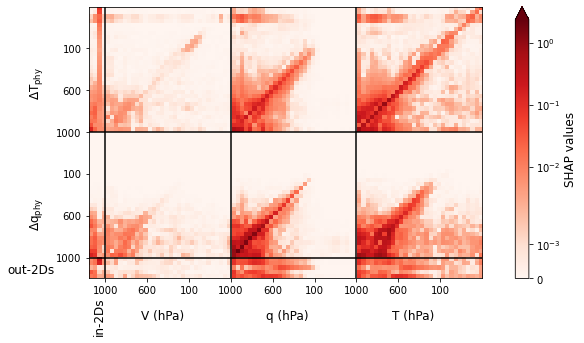

In [19]:
matrix = plot_matrix_shap(
    clima_case,
    nn_case,
    metric,
    input_dict_inv_remap_var, 
    dict_outputs_idxs,
    
    singlenn_shap_matrix,
    # causalnn_thr_shap_matrix,
    # causalnn_thrs_shap_matrix,

    # shap_matrix_diff,
    # diff=True,
    # interpolation='gaussian',
    
    save=save,
    savenm=savenm,

    # cmap='Blues',
    # extend='max',
)